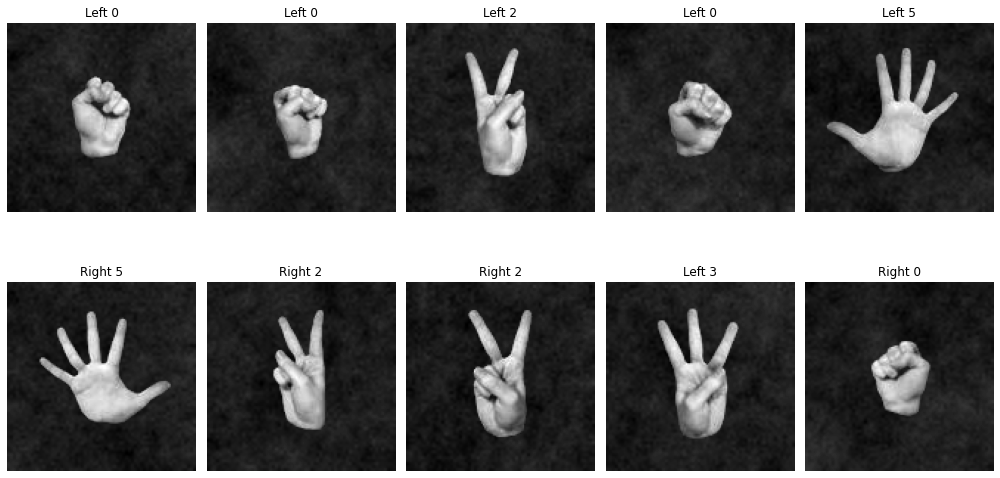

In [1]:
import os
from PIL import Image
import matplotlib.pyplot  as plt

def visua_img(file_path,n=10):
    
    img_list=os.listdir(file_path)
    fig,ax=plt.subplots(n//5,5,figsize=(14,8))
    
    for i,img_name in enumerate(img_list[:n]):
        img= Image.open(file_path+img_name)
        n_label=img_name[-6]
        hand_label=img_name[-5]
        ax[i//5][i%5].imshow(img,cmap='gray')
        ax[i//5][i%5].axis('off')
        ax[i//5][i%5].set_title('{} {}'.format( 'Left' if hand_label=='L' else 'Right',n_label))
    plt.tight_layout()
    plt.show()
    
visua_img('../fingers/train/',10)

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset
from torch import nn

seed = torch.initial_seed()

train_batch_size = 36  # Define train batch size
test_batch_size = 120  # Define test batch size (can be larger than train batch size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device='cpu'
print(device)



# define class to build dataset
class BuildDataset(Dataset):
    def __init__(self,file_path,transform,):
        self.file_path=file_path
        self.transform=transform
        self.image_list= os.listdir(file_path)       # list of image names
        random.shuffle(self.image_list)
        
    def __getitem__(self, idx):

        image_name = self.image_list[idx]
        # label 1 for left or right hand, label 2 for fingers count
        # label 1 : 'Left(L)' for 1, and 'Right(R)' for 0
        data, label1, label2 = Image.open(self.file_path+image_name), image_name[-5:-4], image_name[-6:-5]   
        label1 = int(label1=='L')
        label2= int(label2)

        return self.transform(data).to(device), {'A': torch.tensor(label1), 'B':torch.tensor(label2)}
    
    def __len__(self):
        return len(self.image_list)
    
trf = T.Compose([T.ToTensor(), 
             T.Normalize((0.5,),(0.5,))])
train_dataset=BuildDataset('../fingers/train/',trf)
test_dataset=BuildDataset('../fingers/test/',trf)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
)

len_train=len(train_loader)
len_val=len(test_loader)
print(len_train)
print(len_val)

cuda:0
500
30


In [4]:
# encoder for shared layers (CONVs)
class Encoder(nn.Module):
  def __init__(self,out_channels=72):
    super().__init__()
    self.out_channels=out_channels
    self.encoder = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=48, kernel_size=11, stride=3, padding=0, bias=False),
      nn.BatchNorm2d(48),
      nn.ReLU(inplace=True),
      
      nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, stride=1, padding=2,bias=False),
      nn.BatchNorm2d(96),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(in_channels=192, out_channels=self.out_channels, kernel_size=2, stride=2, padding=0),
      nn.ReLU(inplace=True),
  )
  def forward(self, input):
    shared = self.encoder(input)
    return shared.view(shared.size(0),5*5*self.out_channels)

# decoder for task specific layers(FCs)
class Decoder(nn.Module):
  def __init__(self, in_channel=72,num_classes=None):
    super().__init__()
    self.decoder=nn.Sequential(
            nn.Dropout(),
            nn.Linear(5*5*in_channel, 3*6*20),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*20, 3*4*4),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*4,num_classes),
        )
    self.classifier=nn.Softmax(dim=1)

  def forward(self,shared_layer):
    task_out=self.decoder(shared_layer)
    task_out=self.classifier(task_out)
    return task_out
        


In [5]:
from torch.nn.modules.loss import CrossEntropyLoss
import torch, argparse

from LibMTL import Trainer
from LibMTL.loss import CELoss
from LibMTL.model import resnet18
from LibMTL.utils import set_random_seed, set_device
from LibMTL.config import LibMTL_args, prepare_args
import LibMTL.weighting as weighting_method
import LibMTL.architecture as architecture_method
import LibMTL.metrics as metrics

class DummyParams():
  def __init__(self, ):
    self.weighting='RLW'
    self.arch='HPS'
    self.rep_grad=False
    self.multi_input=False
    self.optim='adam'
    #self.schedule='step'
    self.lr=0.0001
    self.weight_decay=1e-6
    self.scheduler=None
    self.seed=0
    self.gpu_id='0'


def main(params):
    kwargs, optim_param, scheduler_param = prepare_args(params)
    # define tasks: A for left/right hand, B for finger counts
    task_dict = {'A': {'metrics':['accuracy'], 
                              'metrics_fn': metrics.AccMetric(),
                              'loss_fn': CELoss(),
                              'weight': [1]}, 
                 'B': {'metrics':['accuracy'], 
                           'metrics_fn': metrics.AccMetric(),
                           'loss_fn': CELoss(),
                           'weight': [1]}}
    
    # define encoder and decoders
    out_channel_last_shared = 72

    num_classes = {'A':2, 'B':6}
    decoders = nn.ModuleDict({task: Decoder(out_channel_last_shared, 
                                                num_classes[task]) for task in list(task_dict.keys())})
    class trainer(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class, 
                     decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(trainer, self).__init__(task_dict=task_dict, 
                                            encoder_class=encoder_class, 
                                            weighting=weighting_method.__dict__[weighting], 
                                            architecture=architecture_method.__dict__[architecture], 
                                            decoders=decoders,
                                            rep_grad=rep_grad,
                                            multi_input=multi_input,
                                            optim_param=optim_param,
                                            scheduler_param=scheduler_param,
                                            **kwargs)
    
    fingers_model = trainer(task_dict=task_dict, 
                          weighting=params.weighting, 
                          architecture=params.arch, 
                          encoder_class=Encoder, 
                          decoders=decoders,
                          rep_grad=params.rep_grad,
                          multi_input=params.multi_input,
                          optim_param=optim_param,
                          scheduler_param=scheduler_param,
                          **kwargs)
    return fingers_model
if __name__ == "__main__":
    #params = parse_args(LibMTL_args)
    # set device
    #set_device(params.gpu_id)
    # set random seed
    #set_random_seed(params.seed)
    
    params = DummyParams()
    fingers_model = main(params)
    loss_list = fingers_model.train(train_loader,test_loader,10,return_loss=True,save_best_state=True)

General Configuration:
	Wighting: RLW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 0
	Device: cuda:0
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-06
Total Params: 2006480
Trainable Params: 2006480
Non-trainable Params: 0
LOG FORMAT | A_LOSS accuracy | B_LOSS accuracy | TIME
Epoch: 0000 | TRAIN: 0.3674 0.9424 | 1.2035 0.8448 | Time: 211.0677 | TEST: 0.3141 0.9992 | 1.0701 0.9739 | Time: 23.5105
Epoch: 0001 | TRAIN: 0.3158 0.9976 | 1.0708 0.9745 | Time: 209.3073 | TEST: 0.3133 1.0000 | 1.0558 0.9875 | Time: 26.4208
Epoch: 0002 | TRAIN: 0.3154 0.9979 | 1.0561 0.9889 | Time: 211.3232 | TEST: 0.3133 1.0000 | 1.0469 0.9972 | Time: 23.7233
Epoch: 0003 | TRAIN: 0.3149 0.9983 | 1.0498 0.9946 | Time: 204.6268 | TEST: 0.3133 1.0000 | 1.0450 0.9989 | Time: 23.5394
Epoch: 0004 | TRAIN: 0.3142 0.9990 | 1.0493 0.9948 | Time: 211.7168 | TEST: 0.3133 1.0000 | 1.0444 0.9992 | Time: 24.1967
Epoch: 0005 | TRAIN: 0.3143 0.9988 | 1.0466 0.9976 | Time: 211.1353 | TEST

In [6]:
## load the model state dict
#checkpoint = torch.load('./Checkpoint_0.pth')
#model_state_dict = checkpoint['state_dict']

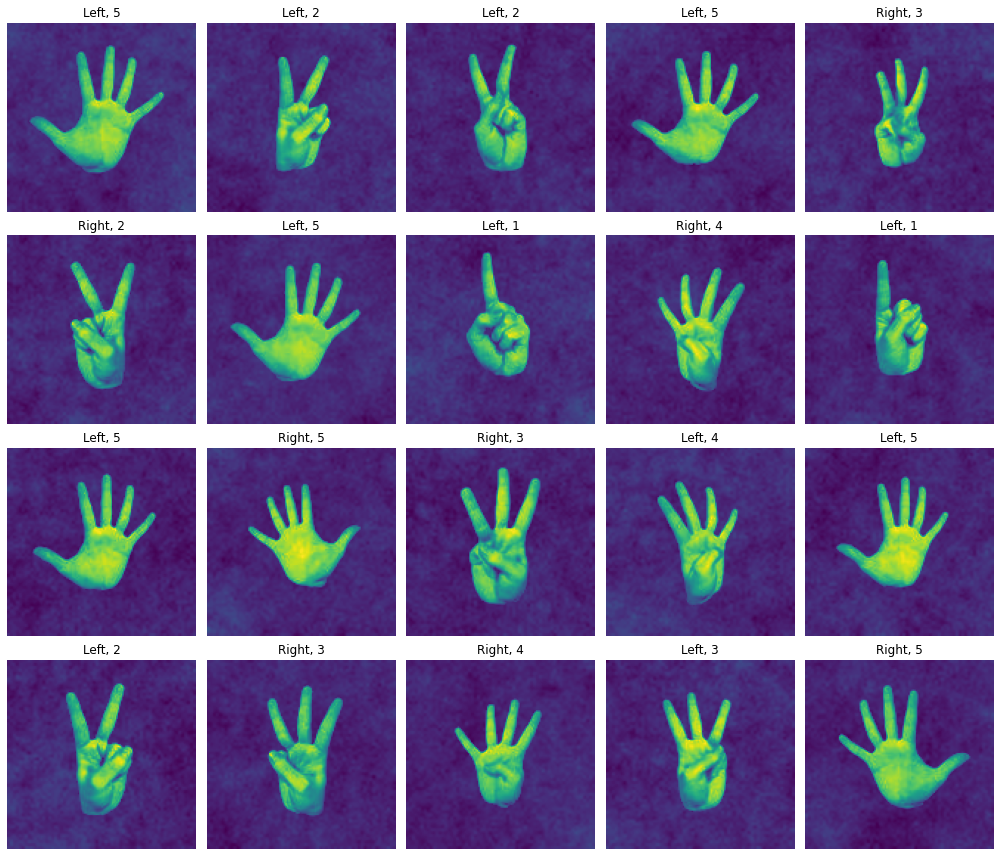

In [15]:
def get_prediction(file_path, num, transform):
    
    imgs = os.listdir(file_path)
    random.shuffle(imgs)
    imgs=imgs[:num]
    imgs=[Image.open(file_path+i) for i in imgs]


    inp = list(map(lambda x: transform(x) , imgs))
    inp = torch.stack(inp,dim=0)
    inp=inp.to(device)    
    
    pred= fingers_model.model(inp)
    pred1, pred2 = pred['A'],pred['B']
    
    def label_pred(pred1,pred2):
        l1=torch.argmax(pred1).item()
        l2=torch.argmax(pred2).item()
        return ('Left, ' if l1==1 else 'Right, ')+str(l2)
        
    pred= (lambda x,y: [label_pred(x[i],y[i]) for i in range(len(pred1))])(pred1,pred2)
    
    fig,ax = plt.subplots(num//5,5,figsize=(14,12))
    for idx,image in enumerate(imgs):
        img=imgs[idx]
        ax[idx//5][idx%5].axis('off')
        ax[idx//5][idx%5].imshow(img)
        ax[idx//5][idx%5].set_title(pred[idx])
    fig.tight_layout()
    plt.show()
        
    pass
        
n_pred=20

get_prediction('../fingers/test/',n_pred, trf)